<a href="https://colab.research.google.com/github/lunaB/AI-Study/blob/master/9_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import numpy as np

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar10_train = datasets.CIFAR10(root='cifar10_data/',
                          train=True,
                          transform=transform,
                          download=True)

cifar10_test = datasets.CIFAR10(root='cifar10_data/',
                         train=False,
                         transform=transform,
                         download=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# VGG는 224*224 사이즈를 기준으로 만들어졌지만 구현할때는 cifar10(3*32*32) 을 사용해보도록함
print(cifar10_train.data.shape)
print(cifar10_train)
print(cifar10_test)

(50000, 32, 32, 3)
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [0]:
class VGG(nn.Module):  
    def __init__(self, features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        
        self.features = features #convolution
        
        # inputsize가 32이라서 maxpooling을 3번거치면 4*4가되서 avgpoo로 더 줄이기 애매해짐 
        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )#FC layer
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) #Convolution 
        # x = self.avgpool(x) # avgpool #제외
        x = x.view(x.size(0), -1) # 
        x = self.classifier(x) #FC layer
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [5]:
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'custom' : [64,64,64,'M',128,128,128,'M',256,256,256,'M']
}

def make_layers(cfg, batch_norm=False): 
    layers = []
    in_channels = 3
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers)

model = VGG(make_layers(cfg['custom']), num_classes=10, init_weights=True).to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [6]:
dataloader = torch.utils.data.DataLoader(cifar10_train, 100, shuffle=True, drop_last=True)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
n_epoch = 15

model.train()
for epoch in tqdm_notebook(range(n_epoch+1)):
    batch_loss = 0
    for idx, mini_batch in enumerate(dataloader):
        x_train, y_train = mini_batch
        x_train = x_train.view(-1, 3, 32, 32).to(device)
        y_train = y_train.to(device)
        
        pred = model(x_train)

        loss = F.cross_entropy(pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
    print('epoch :',epoch+1, 'loss :', batch_loss/len(dataloader))
    batch_loss = 0

epoch : 1 loss : 1.9622350404262543
epoch : 2 loss : 1.4424459495544433
epoch : 3 loss : 1.1471219720840453
epoch : 4 loss : 0.9529025884866714
epoch : 5 loss : 0.8077582046985626
epoch : 6 loss : 0.6973330684900284
epoch : 7 loss : 0.6029318951964379
epoch : 8 loss : 0.5181042454838752
epoch : 9 loss : 0.4357897420525551
epoch : 10 loss : 0.36199160531163216
epoch : 11 loss : 0.29901259738206865
epoch : 12 loss : 0.2500204754918814
epoch : 13 loss : 0.19645984994620086
epoch : 14 loss : 0.16715032080560924
epoch : 15 loss : 0.13755072288215162
epoch : 16 loss : 0.11386530585959553



target : frog
output : frog
normalize된 사진이라 원본사진은 아님


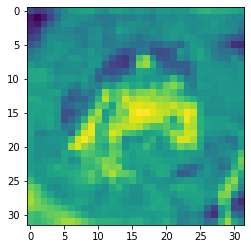

In [7]:
dataloader = torch.utils.data.DataLoader(cifar10_train, 100, shuffle=True, drop_last=True)
model.eval()
x_train, y_train = dataloader.dataset[0]
data = model(x_train.view(-1, 3, 32, 32).to(device)).detach()[0]
print('target :' ,classes[y_train])
print('output :', classes[torch.argmax(data)])
print('normalize된 사진이라 원본사진은 아님')
plt.imshow(x_train[0])
plt.show()

In [8]:
dataloader = torch.utils.data.DataLoader(cifar10_train, 100, shuffle=True, drop_last=True)
model.eval()
with torch.no_grad():
    tmp = []
    for data in dataloader:
        x_data, y_data = data
        pred = model(x_data.view(-1, 3, 32, 32).float().to(device))
        tmp.append((y_data.to(device) == torch.argmax(pred, 1)).float().mean().item())
    print('Train Accuracy : %.2f%%'%(np.array(tmp).mean()*100))

Train Accuracy : 97.69%


In [9]:
dataloader = torch.utils.data.DataLoader(cifar10_test, 100, shuffle=True, drop_last=True)
model.eval()
with torch.no_grad():
    tmp = []
    for data in dataloader:
        x_data, y_data = data
        pred = model(x_data.view(-1, 3, 32, 32).float().to(device))
        tmp.append((y_data.to(device) == torch.argmax(pred, 1)).float().mean().item())
    print('Test Accuracy : %.2f%%'%(np.array(tmp).mean()*100))

Test Accuracy : 78.73%
